In [13]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import progressbar

from HelperAndMechanics import *
from scipy.ndimage import gaussian_filter1d
import jax.numpy as jnp
from jax import jit

# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 10}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [14]:
N = 15000
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_var_l.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()
#normalize each point
x_temp = x_temp-x_cm_temp[0,:,:,:]

dA_diff = np.diff(dA, axis=0)
min_derivative = np.min(dA_diff,axis=0)
max_derivative = np.max(dA_diff,axis=0)
dA_diff = (dA_diff - min_derivative)/(max_derivative-min_derivative)

In [15]:
def shape_data(x_temp,x_cm_temp,dA,y_train_raw,x_arr_fit_raw,i,j,number_of_comp,grid_length,delta_t,key= 'dA_r_0'):
    '''takes in the raw data and shapes it into the correct format for euclidean_distance_trajectory
    shape input
    x_arr_train_flattened_raw: (Dim_x, 1,1, len_t_train)
    x_arr_fit_flattened_raw: (Dim_x, 1,1, len_t_fit)'''
    
    if key == "x":
        x_arr_train_raw = np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]])
        x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)       

        #x_arr_fit_raw = np.array([x_temp[t_start_fit:t_stop_fit,:,i,j],x_temp[t_start_fit:t_stop_fit,:,i,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j]])
        x_arr_fit = np.swapaxes(x_arr_fit_raw,1,2)
        x_arr_fit_flattened_raw = x_arr_fit.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw

        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)
        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.swapaxes(np.array([x_temp[:,:,i,j],x_temp[:,:,i,j+1],x_temp[:,:,i+1,j+1],x_temp[:,:,i+1,j]]),1,2)
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0]*x_arr_train.shape[1], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)

    if key == "dA_r_0_derivative11":
        der = np.diff(dA[:,i,j],axis = 0)
        der = np.append(der,der[-1])
        x_arr_train = np.array([dA[:,i,j],der])
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0 ], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                der = np.diff(dA[:,i,j],axis = 0)
                der = np.append(der,der[-1])
                x_arr_train_temp = np.array([dA[:,i,j],der])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)
    
    if key == "dA_r_0_derivative":
        der = np.diff(dA[:,i,j],axis = 0)
        der = np.append(der,der[-1])
        x_arr_train = np.array([der])
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0 ], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                der = np.diff(dA[:,i,j],axis = 0)
                der = np.append(der,der[-1])
                x_arr_train_temp = np.array([der])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)

    if key == "dA_r_0":
        x_arr_train = np.array([dA[:,i,j]])
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0 ], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.array([dA[:,i,j]])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)
    
    if key == "dA_r_05":
        x_arr_train = np.array([dA[:,i,j],dA[:,i,j+1],dA[:,i+1,j],dA[:,i-1,j],dA[:,i,j-1]])
        
        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.array([dA[:,i,j],dA[:,i,j+1],dA[:,i+1,j],dA[:,i-1,j],dA[:,i,j-1]])
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)


    if key == "dA_r_05_derivative":
        x_arr_train = np.array([dA[:,i,j],dA[:,i,j+1],dA[:,i+1,j],dA[:,i-1,j],dA[:,i,j-1]])
        x_arr_train = np.append(np.diff(x_arr_train,axis = 1),np.diff(x_arr_train[:,-1].reshape(5,1),axis = 1),axis=1)

        x_arr_train_flattened_raw = x_arr_train.reshape(x_arr_train.shape[0], 1 ,1, -1)       

        x_arr_fit_flattened_raw = x_arr_fit_raw.reshape(x_arr_train.shape[0], 1, 1, -1)          
        x_arr_fit_flattened = x_arr_fit_flattened_raw
        y_train = y_train_raw[:,i,j].reshape(y_train_raw.shape[0],1)

        a = int(100/grid_length)
        for i_y in range(grid_length-1):
            for i_x in range(grid_length-1):
                i = int(a/2) + i_y * a
                j = int(a/2) + i_x * a
                x_arr_train_temp = np.array([dA[:,i,j],dA[:,i,j+1],dA[:,i+1,j],dA[:,i-1,j],dA[:,i,j-1]])
                x_arr_train_temp = np.append(np.diff(x_arr_train_temp,axis = 1),np.diff(x_arr_train_temp[:,-1].reshape(5,1),axis = 1),axis=1)
                x_arr_train_flattened_temp = x_arr_train_temp.reshape(x_arr_train.shape[0], 1 ,1, -1)    
                x_arr_train_flattened_raw = np.concatenate((x_arr_train_flattened_raw ,x_arr_train_flattened_temp),axis = 2) 
                y_train = np.concatenate((y_train,y_train_raw[:,i,j].reshape(y_train.shape[0],1)),axis = 1)

    x_arr_train_flattened = x_arr_train_flattened_raw
    x_arr_fit_flattened = x_arr_fit_flattened_raw
    #concentate different time shifts of the data
    for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
        if shift == 0:
            continue
        else:
            x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=3)
            x_arr_fit_flattened_shifted = np.roll(x_arr_fit_flattened_raw,shift * delta_t, axis=3)
            x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
            x_arr_fit_flattened = np.concatenate((x_arr_fit_flattened,x_arr_fit_flattened_shifted),axis=1)
    print('x_arr_train_flattended.shape=',x_arr_train_flattened.shape)
    return x_arr_train_flattened, x_arr_fit_flattened, np.swapaxes((y_train),0,1)

def euclidean_distance_trajectory(x_arr_fit_flattened, x_arr_train_flattened,y_train):
    '''calculate the euclidean distance between the fit and training data. choses shorfit eucledean distance
    shape input 
    x_arr_fit_flattened: (Dim_x, number_of_comp, 1,len_t_fit)
    x_arr_train_flattened: (Dim_x, number_of_comp, number_of_data_points,len_t_train)
    returns an tuple of indices that gives the index of the corresponding training data and time'''

    x_arr_train_flattened = jnp.array(x_arr_train_flattened)
    x_arr_fit_flattened = jnp.array(x_arr_fit_flattened)

    bar = progressbar.ProgressBar(maxval=x_arr_fit_flattened.shape[3], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    y_out = np.zeros(x_arr_fit_flattened.shape[3])
    for current_index in range(x_arr_fit_flattened.shape[3]):

        avg_arr = np.zeros(x_arr_fit_flattened.shape[3])
        bar.update(current_index)
        avg = euclidean_dist_top_k(x_arr_fit_flattened, x_arr_train_flattened,current_index,y_train)
        avg_arr[:avg.shape[0]] = avg
        start = current_index - avg.shape[0]//2
        
        y_out += np.roll(avg_arr,start,axis = 0)
        
    return y_out

@jit
def euclidean_dist_top_k(x_arr_fit_flattened, x_arr_train_flattened, current_index,y_train):
    """
    Calculate the Euclidean distances between fit and training data, 
    and find the indices of the k smallest distances.

    Parameters:
    x_arr_fit_flattened: ndarray (Dim_x, no_dt, 1, len_t_fit)
        fit data array, flattened along the time dimension.
    x_arr_train_flattened: ndarray (Dim_x, no_dt, number_of_data_points, len_t_train)
        Training data array, flattened along the time dimension.
    current_index: int
        Index of the current time step in the fit data.
    k: int
        Number of smallest distances to retrieve.

    Returns:
    tuple
        Indices of the k smallest distances in the training data (as multi-dimensional indices).
    """
    x_current = x_arr_fit_flattened[:, :, 0, current_index]
    x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1, 1)
    k=500
    
    squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
    
    sum_squared_differences = jnp.sum(squared_differences, axis=0)  
    sum_squared_differences = jnp.sum(sum_squared_differences, axis=0)  
    
    flattened_distances = sum_squared_differences.flatten()
    
    # Find the k smallest distances using jnp.argpartition
    smallest_indices_flat = jnp.argpartition(flattened_distances, k)[:k]  # Indices of k smallest distances
    
    # Sort the k smallest distances for ordered output
    sorted_indices_flat = smallest_indices_flat[jnp.argsort(flattened_distances[smallest_indices_flat])]
    # Convert flattened indices to multi-dimensional indices
    indices = jnp.unravel_index(sorted_indices_flat, sum_squared_differences.shape)


    time_window = 100
    time_steps = y_train.shape[1]  

    # Create time offsets: [-10, -9, ..., 0, ..., 9, 10]
    time_offsets = jnp.arange(-time_window, time_window + 1)  # Shape (time_window,)
    # Compute full time indices for all rows (k rows x time_window time offsets)
    time_indices = indices[1][:, None] + time_offsets  # Shape (k, time_window)
    # Clip to valid time range [0, time_steps - 1]
    time_indices = jnp.clip(time_indices, 0, time_steps - 1)
    # Gather values from y_train
    # Row indices (k rows repeated time_window times each)
    row_indices = indices[0][:, None]  # Shape (k, 1)
    # Use advanced indexing to gather data
    next_neighbours = y_train[row_indices, time_indices]  # Shape (k, time_window)


    weigths = (1.1-(sum_squared_differences[row_indices,time_indices]**2/jnp.max(sum_squared_differences[row_indices,time_indices])**2))**4

    avg = jnp.sum(next_neighbours*weigths,axis =0)/jnp.sum(weigths,axis =0)
    
    x = np.arange(avg.shape[0]) - avg.shape[0] // 2  # Centered at the middle
    sigma = avg.shape[0] / 4
    gaussian = np.exp(-x**2 / (2 * sigma**2))
    avg = avg * gaussian/np.sum(gaussian)

    return avg

In [16]:
t_start,t_stop = 0,T.shape[0]-3000
i,j = 50,60
T.shape[0]

15000

In [17]:
T_arr_indx = [[i-1,j-1],[i-1,j],[i,j],[i,j-1]]

dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001
max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)

t_start_fit = t_stop + 500 + maxima_temp0[max_indx] - 300
t_stop_fit = t_stop + 500+ minima_temp0[min_indx+1] + 700

T_arr = np.zeros((4,t_stop_fit-t_start_fit))


#define Hyperparameters
no_dt,no_points = 30,10
delta_t = 20
for indx in range(4):
    i,j = T_arr_indx[indx]
    dA_r_0_der_raw = np.append(np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0),np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0)[-1])
    
    x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_0_der_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_0_derivative")
    print('calculating element',indx)
    y_out_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)

    T_arr[indx,:] = y_out_diff

np.save('T_rec_test.npy',T_arr)
x_arr_fit_raw = np.array([x_temp[t_start_fit:t_stop_fit,:,i,j],x_temp[t_start_fit:t_stop_fit,:,i,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j+1],x_temp[t_start_fit:t_stop_fit,:,i+1,j]])
dA_r_0_raw = dA[t_start_fit:t_stop_fit,i,j] - dA[t_start_fit,i,j]
dA_r_0_der_raw = np.append(np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0),np.diff(dA[t_start_fit:t_stop_fit,i,j],axis = 0)[-1])
dA_r_05_raw = np.array([dA[t_start_fit:t_stop_fit,i,j],dA[t_start_fit:t_stop_fit,i,j+1],dA[t_start_fit:t_stop_fit,i+1,j],dA[t_start_fit:t_stop_fit,i-1,j],dA[t_start_fit:t_stop_fit,i,j-1]])
dA_r_05_der_raw = np.append(np.diff(dA_r_05_raw,axis = 1),np.diff(dA_r_05_raw,axis = 1)[:,-1].reshape(5,1),axis = 1)


x_arr_train_flattended.shape= (1, 31, 82, 12000)
calculating element 0


x_arr_train_flattended.shape= (1, 31, 82, 12000)
calculating element 1


x_arr_train_flattended.shape= (1, 31, 82, 12000)
calculating element 2


x_arr_train_flattended.shape= (1, 31, 82, 12000)
calculating element 3


In [18]:
x_train,x_fit, y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_0_raw,i,j,no_dt,no_points,delta_t)
#y_out = euclidean_distance_trajectory(x_fit, x_train,y_train)
x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_0_der_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_0_derivative")
y_out_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)
x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_05_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_05")
#y_out_05 = euclidean_distance_trajectory(x_fit, x_train,y_train)
x_train,x_fit,y_train = shape_data(x_temp,x_cm_temp,dA[t_start:t_stop,:,:],T[t_start:t_stop,:,:],dA_r_05_der_raw,i,j,no_dt,no_points,delta_t,key = "dA_r_05_derivative")
#y_out_05_diff = euclidean_distance_trajectory(x_fit, x_train,y_train)

x_arr_train_flattended.shape= (1, 31, 82, 12000)


x_arr_train_flattended.shape= (1, 31, 82, 12000)


KeyboardInterrupt: 

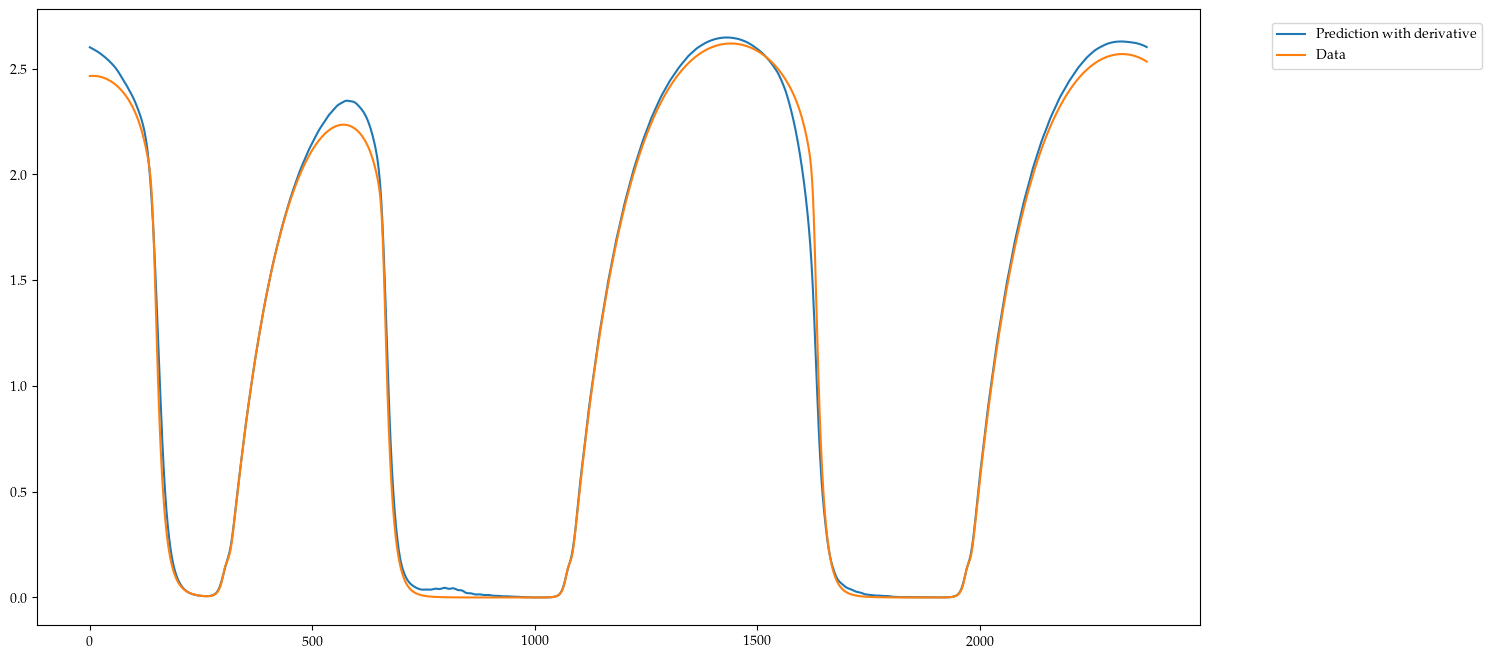

In [ ]:
T_fit_raw = T[t_start_fit:t_stop_fit,i,j]

plt.figure(figsize=(15,8))
#plt.plot(y_out,label='Prediction')
plt.plot(y_out_diff,label='Prediction with derivative')
#plt.plot(y_out_05,label='Prediction with 5 points')
#plt.plot(y_out_05_diff,label='Prediction with 5 points and derivative')
plt.plot(T_fit_raw,label='Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=1)
#plt.savefig('test.png')

In [ ]:
loss = np.sum((y_out[300:1300] - T_fit_raw[300:1300])**2)
loss_diff = np.sum((y_out_diff[300:1300] - T_fit_raw[300:1300])**2)
print('loss =',loss,'loss_diff =',loss_diff)

NameError: name 'y_out' is not defined

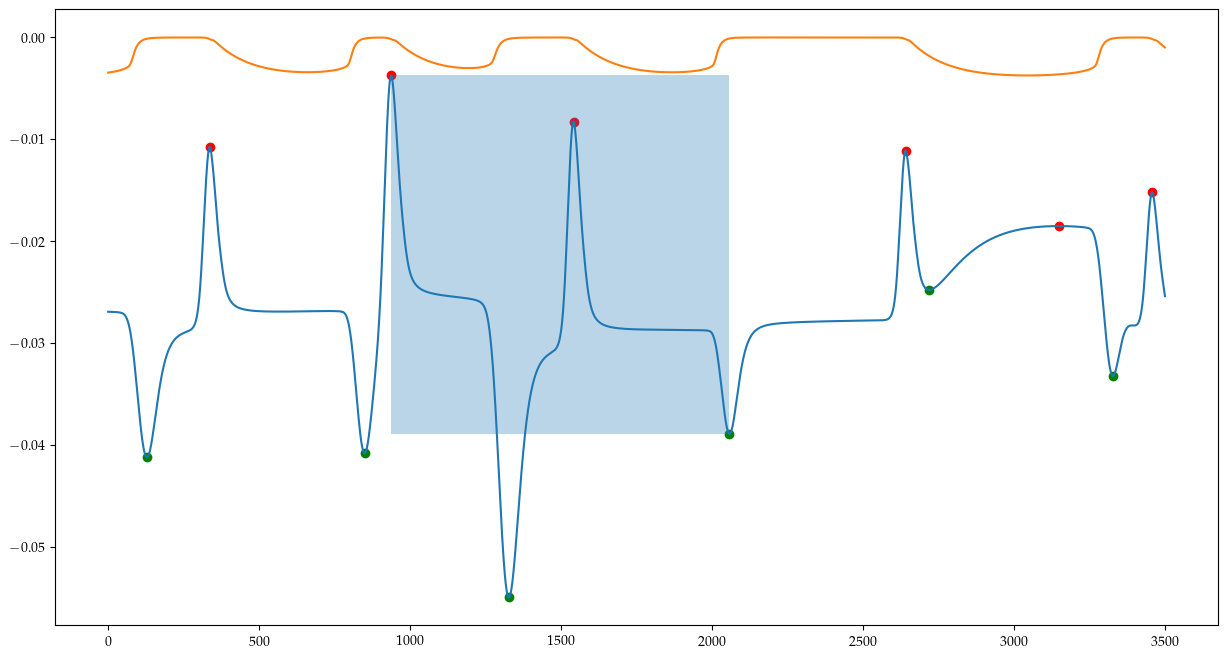

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx+1]],dA_test[minima_temp0[min_indx+1]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))

t_start_fit = t_stop + 500 + maxima_temp0[max_indx] - 300
t_stop_fit = t_stop + 500+ minima_temp0[min_indx+1] + 500

In [ ]:
losses = np.load('../data/SpringMassModel/NearestNeighbourReconstruction/eval_hyps2.npy')

/tmp/ipykernel_9074/2114096428.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar


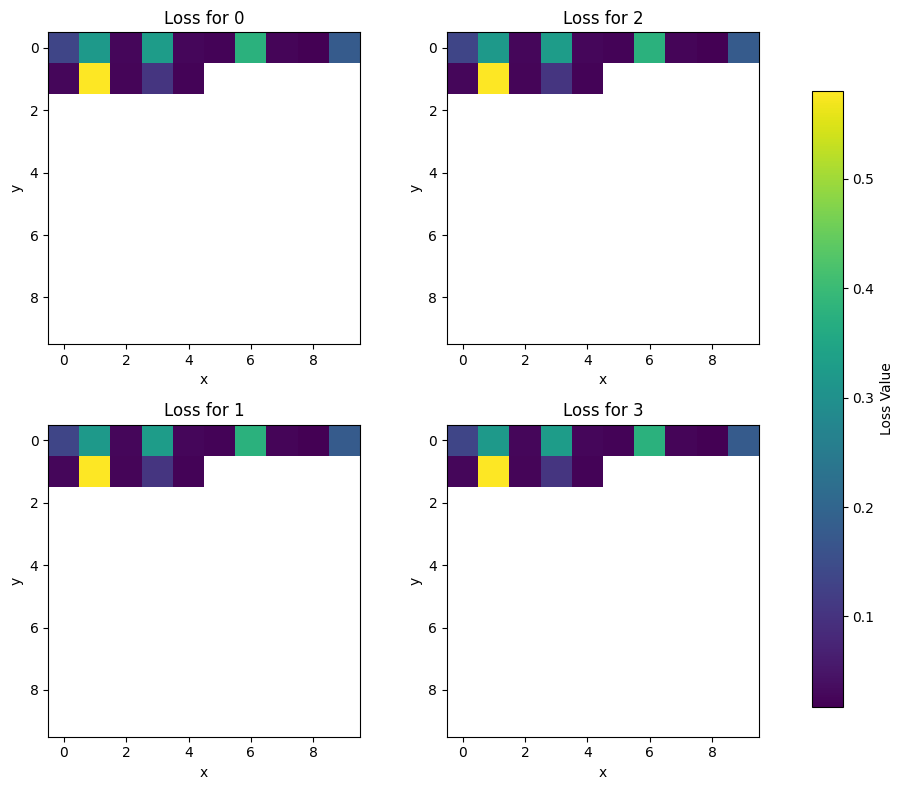

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Find the global vmin and vmax for consistent color scaling
vmin = np.nanmin(losses[:, :, :, 1])
vmax = np.nanmax(losses[:, :, :, 1])

# Create the subplots and use a single colorbar
for i in range(2):
    for j in range(2):
        im = axs[i, j].imshow(
            losses[:, :, i + j * 2, 1],
            cmap='viridis',
            interpolation='nearest',
            vmin=vmin,
            vmax=vmax
        )
        axs[i, j].set_title(f'Loss for {i + j * 2}')
        axs[i, j].set_xlabel('x')
        axs[i, j].set_ylabel('y')

# Add a single colorbar outside the figure
cbar = fig.colorbar(
    im,
    ax=axs,
    orientation='vertical',  # 'horizontal' for below the figure
    fraction=0.08,           # Fraction of original axes height
    pad=0.1                  # Padding between the figure and the colorbar
)
cbar.set_label('Loss Value')

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to make space for the colorbar
plt.show()

